# Load Necessary Packages

In [1]:
import pandas as pd
import numpy as np
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from xgboost import XGBClassifier, XGBRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.inspection import permutation_importance
from scipy.stats import mstats
from sklearn.preprocessing import FunctionTransformer
import numpy as np
import statsmodels.api as sm
from scipy import stats

---

# Reading in Data & Performing Exploratory Analysis

In [4]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)  #avoid displaying values in scientific notation

Original_Data = pd.read_parquet('final_cleaned_capstone_data.parquet')

#convert datetime to seconds for ease of modeling
Original_Data['program_current_premiere_date'] = pd.to_datetime(Original_Data['program_current_premiere_date']).astype('int64') // 10**9

print(Original_Data.shape)
Original_Data.head()

(3966, 29)


,Program,Partner - Episode Duration,Program - Broadcast Length,Exposures,Minutes Viewed,NO.of Scheduled Minutes,NO.of Telecasts,program_current_premiere_date,Month,Year,...,Program - Production Year,Program - Sub Category,Program - Supplier,Program Sub-Type,premiere_year,Series Type,Exposures_top25p_thrshld,Mins_vewd_top25p_thrshld,Exposures_success,Mins_vewd_success
0,american pickers_235262.0,3600.00000,60.00000,9131449.36644,395921557.99276,15616376,17,1641600,jun,2022,...,2020.0,artifactual & transactional,cineflix international media limited,unscripted,2022,legacy,2712845.45326,112179664.79778,1,1
1,american pickers: best of_268226.0,3600.00000,60.00000,1264500.65751,55396322.38638,5689563,2,1658534,jul,2023,...,2022.0,artifactual & transactional,stamford post production,unscripted,2022,legacy,2712845.45326,112179664.79778,0,0
2,barrett-jackson: revved up_287325.0,3600.00000,60.00000,66008.54860,2699097.86541,204598,2,1693699,sep,2023,...,2023.0,gearhead,stamford post production,unscripted,2023,legacy,2712845.45326,112179664.79778,0,0
3,storage wars_265702.0,1800.00000,30.00000,1451701.69624,30718815.96740,2909038,8,1686614,jun,2023,...,2022.0,artifactual & transactional,"original productions, llc",unscripted,2023,legacy,2712845.45326,112179664.79778,0,0
4,the curse of oak island: digging deeper_283065.0,3600.00000,60.00000,1785780.58369,80449415.29545,119,2,1669680,nov,2022,...,2022.0,investigating history,stamford post production,docu-drama,2022,legacy,6554474.77989,291962386.72339,0,0


<Axes: >

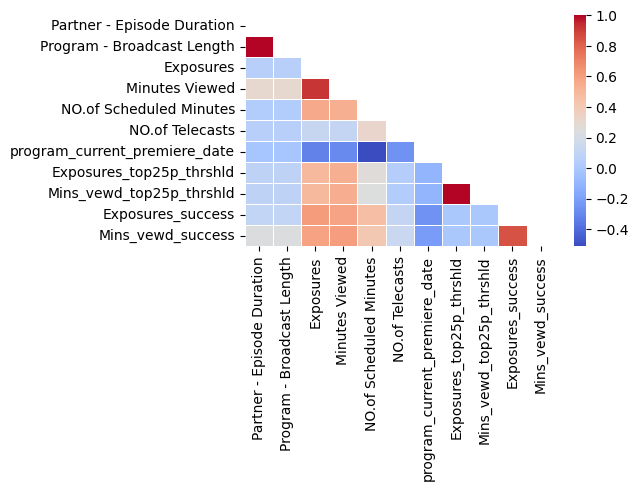

In [5]:
#make variable correlation visual
Corr_DF = Original_Data.select_dtypes(include='number')
corr = Corr_DF.corr()

plt.figure(figsize=(5, 3))
mask = np.triu(np.ones_like(corr, dtype=bool)) #mask for the upper triangle
sns.heatmap(corr, mask=mask, cmap='coolwarm', annot=False, fmt=".2f", linewidths=.5)

---

# Regressor Approach

## Identifying Categorical and Numerical Columns

In [10]:
Cat_Cols = Original_Data.select_dtypes(include=['object']).columns.tolist()
Numer_Cols = Original_Data.select_dtypes(exclude=['object']).columns.tolist()

#remove program name col because no point in making that a predictor variable
Cat_Cols.remove('Program')
Numer_Cols.remove('Exposures')

#remove these from numeric_columns b/c not relevant to analysis
Numer_Cols = list(set(Numer_Cols) - {'Partner - Episode Duration', 'Exposures_top25p_thrshld', 'Mins_vewd_top25p_thrshld', 'Mins_vewd_success', 'Minutes Viewed', 'Exposures_success'}) 

print('numeric_columns:', '\n', Numer_Cols,'\n')
print('categorical_columns:', '\n', Cat_Cols)

numeric_columns: 
 ['Program - Broadcast Length', 'NO.of Scheduled Minutes', 'NO.of Telecasts', 'program_current_premiere_date'] 

categorical_columns: 
 ['Month', 'Year', 'Program - Network', 'Partner - Network', 'Partner - Name', 'Partner - Platform', 'Partner - Device', 'Program - Category', 'Program - Genre Name', 'Program - Mega Genre', 'Program - Network Name', 'Program - Production Year', 'Program - Sub Category', 'Program - Supplier', 'Program Sub-Type', 'premiere_year', 'Series Type']


## Simple Linear Regression to Determine Significant Variables

In [11]:
Dep_Var = 'Exposures'
Indep_Vars = Numer_Cols + Cat_Cols

# One-hot encode categorical variables
X = pd.get_dummies(Original_Data[Indep_Vars], columns=Cat_Cols, drop_first=True)

# Define the target variable (Y) as 'Exposures'
Y = Original_Data[Dep_Var]

# Create and fit the Linear Regression model
Lin_Reg = LinearRegression()
Lin_Reg.fit(X, Y)

# Make predictions (optional)
Y_pred = Lin_Reg.predict(X)

# Evaluate the model (optional)
r2 = r2_score(Y, Y_pred)
print("R² Score:", r2)

R² Score: 0.8146226653775602


In [12]:
Coeffs = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': Lin_Reg.coef_
})

print(Coeffs.sort_values(by='Coefficient', key=abs, ascending=False))

                                               Feature    Coefficient
173  Program - Supplier_endemol shine international...  6055328.37138
161                     Program - Supplier_buena vista  5471693.09513
226                 Program - Supplier_world of wonder -4904673.30976
22                                Partner - Network_cc  3924529.45334
182             Program - Supplier_ipc television, llc  3732394.29381
..                                                 ...            ...
113                     Program - Sub Category_culture    -5009.23113
233                                    Series Type_new    -2978.17420
2                                      NO.of Telecasts      862.95222
3                        program_current_premiere_date       -7.48688
1                              NO.of Scheduled Minutes        0.27456

[235 rows x 2 columns]


In [13]:
Y_Pred = Lin_Reg.predict(X)
Residuals = Y - Y_pred

n = X.shape[0]
k = X.shape[1]

# Step 4: Calculate variance of residuals
RSS = np.sum(Residuals**2)  # Residual Sum of Squares
TSS = np.sum((Y - np.mean(Y))**2)  # Total Sum of Squares
R_squared = 1 - (RSS / TSS)  # R² calculation

# Mean Squared Error of residuals
MSE = RSS / (n - k)

# Step 5: Calculate the variance-covariance matrix for the coefficients
X_with_const = np.concatenate([np.ones((n, 1)), X], axis=1)  # Add intercept
var_b = MSE * (np.linalg.inv(X_with_const.T @ X_with_const).diagonal())

# Step 6: Standard errors of the coefficients
std_err_b = np.sqrt(var_b)

# Step 7: t-statistics for the coefficients
t_stats = Lin_Reg.coef_ / std_err_b[1:]  # Exclude intercept from t-stats

# Step 8: Calculate p-values from the t-statistics
p_values = [2 * (1 - stats.t.cdf(np.abs(t), df=n - k)) for t in t_stats]

# Combine features, coefficients, and p-values into a DataFrame
results = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': Lin_Reg.coef_,
    'P-value': p_values
})

# Sort by p-values to find the most significant features
significant_features = results.sort_values(by='P-value')

# Display the results
print(significant_features)

UFuncTypeError: Cannot cast ufunc 'inv' input from dtype('O') to dtype('float64') with casting rule 'same_kind'

In [85]:
Results = permutation_importance(Lin_Reg, X, Y, n_repeats=10, random_state=42)

# Display the results
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': Results.importances_mean
})
print(importance_df.sort_values(by='Importance', ascending=False))

KeyboardInterrupt: 

## List of Models

In [14]:
# make base models
Models = [
    ('lr', LinearRegression()),
    ('lasso', Lasso()),
    ('ridge', Ridge()),
    ('elastic', ElasticNet()),
    ('rf', RandomForestRegressor()),
    ('gb', GradientBoostingRegressor()),
    ('xgb', XGBRegressor())
]

Ensemble = VotingRegressor(estimators=Models, verbose=False) 

---

## Model Group 1 - Standardized Variables

### Transforming Steps for Model 1

In [15]:
# preprocess numeric cols
Numer_Transformer_1 = make_pipeline( SimpleImputer(strategy='median'), StandardScaler() )

# preprocess categorical cols, make dummy cols using 1hot encoding 
Cat_Transformer_1 = make_pipeline( SimpleImputer(strategy='most_frequent'), OneHotEncoder(handle_unknown='ignore') )

# combine preprocessing steps
Preprocessor_1 = make_column_transformer(
    (Numer_Transformer_1, Numer_Cols),
    (Cat_Transformer_1, Cat_Cols)
)

### Model 1A

In [16]:
# separate features & target
X_1A = Original_Data[Numer_Cols + Cat_Cols] 
y_1A = Original_Data['Exposures']

# split into train & test sets
X_1A_train, X_1A_test, y_1A_train, y_1A_test = train_test_split(X_1A, y_1A, test_size=0.2, random_state=42)

In [17]:
Pipeline_1A = make_pipeline(Preprocessor_1, Ensemble)
Pipeline_1A.fit(X_1A_train, y_1A_train) #fit to model

C:\Users\camer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:589: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1495710770732373.8, tolerance: 1696639724032.2764
  model = cd_fast.sparse_enet_coordinate_descent(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Program - Broadcast Length',
                                                   'NO.of Scheduled Minutes',
                                                   'NO.of Telecasts',
                                                   'program_current_premiere_date']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer...
                                                           grow_policy=None,
                                                           importance_type=None,
                                                           interaction_constraints=None,
                                                           learning_rate=None,
                                                           max_bin=None,
                                                           max_cat_threshold=None,
                                                           max_cat_to_onehot=None,
                                                           max_delta_step=None,
                                                           max_depth=None,
                                                           max_leaves=None,
                                                           min_child_weight=None,
                                                           missing=nan,
                                                           monotone_constraints=None,
                                                           multi_strategy=None,
                                                           n_estimators=None,
                                                           n_jobs=None,
                                                           num_parallel_tree=None,
                                                           random_state=None, ...))]))])

MSE:  461656817648.2522
MAE:  433056.17852718435
R2:  0.8997525738111066


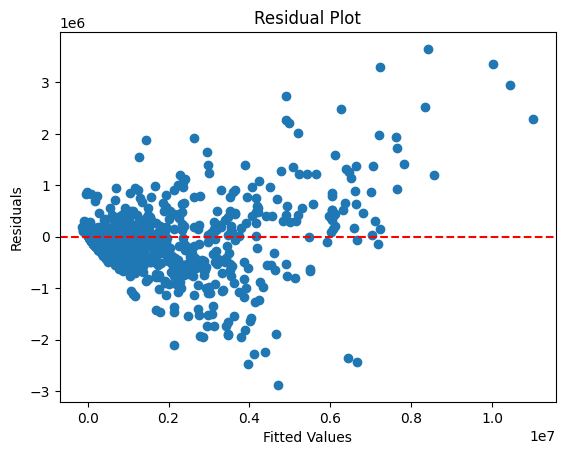

In [18]:
# evaluate the model
Y_1A_Pred = Pipeline_1A.predict(X_1A_test)

print("MSE: ", mean_squared_error(y_1A_test, Y_1A_Pred))
print("MAE: ", mean_absolute_error(y_1A_test, Y_1A_Pred))
print("R2: ", r2_score(y_1A_test, Y_1A_Pred))

Residuals_1A = y_1A_test - Y_1A_Pred
plt.scatter(Y_1A_Pred, Residuals_1A)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

- Model 1A Appears to under-predict medium to large values, performs well with smaller values

### Model 1B - Removing Outliers

In [19]:
Q1 = Original_Data['Exposures'].quantile(0.25)
Q3 = Original_Data['Exposures'].quantile(0.75)
IQR = Q3 - Q1
Lower_Bound = Q1 - 1.5 * IQR
Upper_Bound = Q3 + 1.5 * IQR

# Filter out outliers
DF_No_Outliers = Original_Data[(Original_Data['Exposures'] >= Lower_Bound) & (Original_Data['Exposures'] <= Upper_Bound)]
print(DF_No_Outliers.shape)

# separate features & target
X_1B = DF_No_Outliers[Numer_Cols + Cat_Cols] 
y_1B = DF_No_Outliers['Exposures']

# split into train & test sets
X_1B_train, X_1B_test, y_1B_train, y_1B_test = train_test_split(X_1B, y_1B, test_size=0.2, random_state=42)

(3644, 29)


In [20]:
Pipeline_1B = make_pipeline(Preprocessor_1, Ensemble)
Pipeline_1B.fit(X_1B_train, y_1B_train) #fit to model

C:\Users\camer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:589: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 457339726272720.9, tolerance: 527617066333.8302
  model = cd_fast.sparse_enet_coordinate_descent(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Program - Broadcast Length',
                                                   'NO.of Scheduled Minutes',
                                                   'NO.of Telecasts',
                                                   'program_current_premiere_date']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer...
                                                           grow_policy=None,
                                                           importance_type=None,
                                                           interaction_constraints=None,
                                                           learning_rate=None,
                                                           max_bin=None,
                                                           max_cat_threshold=None,
                                                           max_cat_to_onehot=None,
                                                           max_delta_step=None,
                                                           max_depth=None,
                                                           max_leaves=None,
                                                           min_child_weight=None,
                                                           missing=nan,
                                                           monotone_constraints=None,
                                                           multi_strategy=None,
                                                           n_estimators=None,
                                                           n_jobs=None,
                                                           num_parallel_tree=None,
                                                           random_state=None, ...))]))])

MSE:  224940631914.40622
MAE:  320531.8816208186
R2:  0.8756374492750588


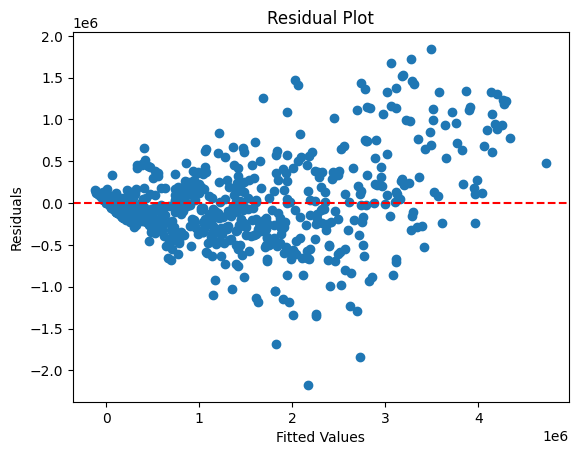

In [21]:
# evaluate the model
Y_1B_Pred = Pipeline_1B.predict(X_1B_test)

print("MSE: ", mean_squared_error(y_1B_test, Y_1B_Pred))
print("MAE: ", mean_absolute_error(y_1B_test, Y_1B_Pred))
print("R2: ", r2_score(y_1B_test, Y_1B_Pred))

Residuals_1B = y_1B_test - Y_1B_Pred
plt.scatter(Y_1B_Pred, Residuals_1B)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

- Significant improvement from Model 1A, but still under-predicting large values

---

## Model 2 - Log Transformation

In [42]:
# preprocess numeric cols using log transformation
Numer_Transformer_2 = make_pipeline(
    SimpleImputer(strategy='median'),
    FunctionTransformer(np.log1p, validate=True)  # Apply log transformation
)

# preprocess categorical cols, make dummy cols using 1hot encoding 
Cat_Transformer_2 = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore')
)

# combine preprocessing steps
Preprocessor_2 = make_column_transformer(
    (Numer_Transformer_2, Numer_Cols),
    (Cat_Transformer_2, Cat_Cols)
)


### Model 2A - Log Transformation on Original Dataset

In [40]:
# separate features & target
X_2A = Original_Data[Numer_Cols + Cat_Cols] 
Y_2A = Original_Data['Exposures']

# split into train & test sets
X_2A_Train, X_2A_Test, Y_2A_Train, Y_2A_Test = train_test_split(X_2A, Y_2A, test_size=0.2, random_state=42)

In [44]:
# Fit the pipeline with log-transformed numeric features
Pipeline_2A = make_pipeline(Preprocessor_2, Ensemble)
Pipeline_2A.fit(X_2A_Train, Y_2A_Train)

C:\Users\camer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:589: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1174491044501321.0, tolerance: 1696639724032.2764
  model = cd_fast.sparse_enet_coordinate_descent(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(func=<ufunc 'log1p'>,
                                                                                       validate=True))]),
                                                  ['Partner - Episode Duration',
                                                   'Program - Broadcast Length',
                                                   'Exposures',
                                                   'Minutes Viewed',
                                                   'NO.of Scheduled Minutes',
                                                   'NO.of Telecast...
                                                           grow_policy=None,
                                                           importance_type=None,
                                                           interaction_constraints=None,
                                                           learning_rate=None,
                                                           max_bin=None,
                                                           max_cat_threshold=None,
                                                           max_cat_to_onehot=None,
                                                           max_delta_step=None,
                                                           max_depth=None,
                                                           max_leaves=None,
                                                           min_child_weight=None,
                                                           missing=nan,
                                                           monotone_constraints=None,
                                                           multi_strategy=None,
                                                           n_estimators=None,
                                                           n_jobs=None,
                                                           num_parallel_tree=None,
                                                           random_state=None, ...))]))])

MSE:  260798837492.0984
MAE:  328312.82628421823
R2:  0.9433682960758127


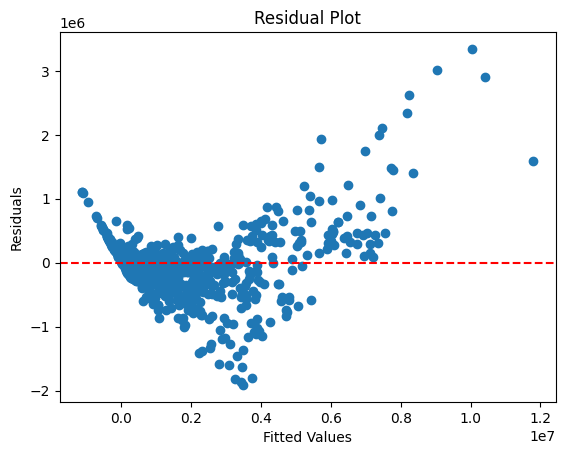

In [45]:
# evaluate the model
Y_2A_Pred = Pipeline_2A.predict(X_2A_Test)

print("MSE: ", mean_squared_error(Y_2A_Test, Y_2A_Pred))
print("MAE: ", mean_absolute_error(Y_2A_Test, Y_2A_Pred))
print("R2: ", r2_score(Y_2A_Test, Y_2A_Pred))

Residuals_2A = Y_2A_Test - Y_2A_Pred
plt.scatter(Y_2A_Pred, Residuals_2A)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

### Model 2B

In [46]:
# separate features & target
X_2B = DF_No_Outliers[Numer_Cols + Cat_Cols] 
Y_2B = DF_No_Outliers['Exposures']

# split into train & test sets
X_2B_Train, X_2B_Test, Y_2B_Train, Y_2B_Test = train_test_split(X_2B, Y_2B, test_size=0.2, random_state=42)

In [47]:
# Fit the pipeline with log-transformed numeric features
Pipeline_2B = make_pipeline(Preprocessor_2, Ensemble)
Pipeline_2B.fit(X_2B_Train, Y_2B_Train)

C:\Users\camer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:589: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 321442393057001.5, tolerance: 527617066333.8302
  model = cd_fast.sparse_enet_coordinate_descent(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(func=<ufunc 'log1p'>,
                                                                                       validate=True))]),
                                                  ['Partner - Episode Duration',
                                                   'Program - Broadcast Length',
                                                   'Exposures',
                                                   'Minutes Viewed',
                                                   'NO.of Scheduled Minutes',
                                                   'NO.of Telecast...
                                                           grow_policy=None,
                                                           importance_type=None,
                                                           interaction_constraints=None,
                                                           learning_rate=None,
                                                           max_bin=None,
                                                           max_cat_threshold=None,
                                                           max_cat_to_onehot=None,
                                                           max_delta_step=None,
                                                           max_depth=None,
                                                           max_leaves=None,
                                                           min_child_weight=None,
                                                           missing=nan,
                                                           monotone_constraints=None,
                                                           multi_strategy=None,
                                                           n_estimators=None,
                                                           n_jobs=None,
                                                           num_parallel_tree=None,
                                                           random_state=None, ...))]))])

MSE:  82942831307.44856
MAE:  198790.97541640495
R2:  0.9541435356611435


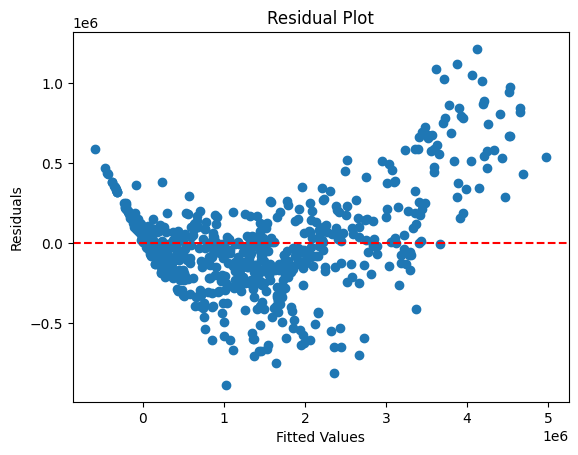

In [49]:
# evaluate the model
Y_2B_Pred = Pipeline_2B.predict(X_2B_Test)

print("MSE: ", mean_squared_error(Y_2B_Test, Y_2B_Pred))
print("MAE: ", mean_absolute_error(Y_2B_Test, Y_2B_Pred))
print("R2: ", r2_score(Y_2B_Test, Y_2B_Pred))

Residuals_2B = Y_2B_Test - Y_2B_Pred
plt.scatter(Y_2B_Pred, Residuals_2B)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()